In [1]:
import HARK.ConsumptionSaving.ConsIndShockModel as Model        # The consumption-saving micro model
import HARK.ConsumptionSaving.ConsumerParameters as Params    # Parameters for the consumer type
from HARK.utilities import plotFuncsDer, plotFuncs              # Some tools
from time import time
mystr = lambda number : "{:.4f}".format(number)
do_simulation = True
import numpy as np
import matplotlib.pyplot as plt

#Notebooks to look for helpful code
# https://github.com/econ-ark/HARK/blob/master/HARK/SolvingMicroDSOPs/Code/StructEstimation.py
# https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsIndShockModel.py
# https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsumerParameters.py
# https://github.com/matthew-zahn/CGMPort/blob/develop/REMARK/CGM_REMARK.ipynb

In [2]:
#Set Parameters

Params.init_lifecycle["CRRA"]= 2.00            # Default coefficient of relative risk aversion (rho)
Params.init_lifecycle["DiscFac"]= 0.96         # Default intertemporal discount factor (beta)
Params.init_lifecycle["PermGroFacAgg"]= 1.0    # Aggregate permanent income growth factor 
Params.init_lifecycle["aNrmInitMean"]= 0       # Mean of log initial assets 
Params.init_lifecycle["aNrmInitStd"]= 0.0      # Standard deviation of log initial assets
Params.init_lifecycle["pLvlInitMean"]= 0.0     # Mean of log initial permanent income 
Params.init_lifecycle["pLvlInitStd"]= 0.0      # Standard deviation of log initial permanent income

Params.init_lifecycle['AgentCount'] = 1000                  #Change the number of agents simulated from default 10000 to 1000

In [15]:
#Unskilled Laborers: 3 percent growth from 25~40. flat for 40~65.

Params.init_lifecycle['PermGroFac'] = [1.03]*15 + [1]*25 + [0.7] + [1]*9     #Oringinally, [1.01,1.01,1.01,1.01,1.01,1.02,1.02,1.02,1.02,1.02]
Params.init_lifecycle['PermShkStd'] = [0.1]*50               #Originally, [0.1,0.2,0.1,0.2,0.1,0.2,0.1,0,0,0]
Params.init_lifecycle['TranShkStd'] = [0.1]*50               #Originally, [0.3,0.2,0.1,0.3,0.2,0.1,0.3,0,0,0]
Params.init_lifecycle['LivPrb']     = [1]*50                 #Originally, [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
Params.init_lifecycle['T_cycle']    = 50                     #Life starts at age 25 and ends at 75. Originally 10
Params.init_lifecycle['T_retire']   = 40                    #Agents retire at age 65. Originally 7
Params.init_lifecycle['T_age']      = 51                    #Make sure that old people die at terminal age and don't turn into newborns! Originally 11

Lifecycle_Unskilled = Model.IndShockConsumerType(**Params.init_lifecycle)
Lifecycle_Unskilled.cycles = 1 #1 for finite horizon and 0 for infinite horizon
Lifecycle_Unskilled.solve()
Lifecycle_Unskilled.unpackcFunc()
Lifecycle_Unskilled.timeFwd() #make sure that time is moving forward

In [16]:
#Operatives: 2.5 percent growth from 25~50. 1 percent growth from 50~65.

Params.init_lifecycle['PermGroFac'] = [1.025]*25 + [1.01]*15 + [0.7] + [1]*9     #Oringinally, [1.01,1.01,1.01,1.01,1.01,1.02,1.02,1.02,1.02,1.02]
Params.init_lifecycle['PermShkStd'] = [0.1]*50               #Originally, [0.1,0.2,0.1,0.2,0.1,0.2,0.1,0,0,0]
Params.init_lifecycle['TranShkStd'] = [0.1]*50               #Originally, [0.3,0.2,0.1,0.3,0.2,0.1,0.3,0,0,0]
Params.init_lifecycle['LivPrb']     = [1]*50                 #Originally, [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
Params.init_lifecycle['T_cycle']    = 50                     #Life starts at age 25 and ends at 75. Originally 10
Params.init_lifecycle['T_retire']   = 40                    #Agents retire at age 65. Originally 7
Params.init_lifecycle['T_age']      = 51                    #Make sure that old people die at terminal age and don't turn into newborns! Originally 11

Lifecycle_Operatives = Model.IndShockConsumerType(**Params.init_lifecycle)
Lifecycle_Operatives.cycles = 1 #1 for finite horizon and 0 for infinite horizon
Lifecycle_Operatives.solve()
Lifecycle_Operatives.unpackcFunc()
Lifecycle_Operatives.timeFwd() #make sure that time is moving forward

In [17]:
#Managers: 3 percent growth from 25~55. 1 percent decline from 55~65.

Params.init_lifecycle['PermGroFac'] = [1.03]*30 + [0.99]*10 + [0.7] + [1]*9     #Oringinally, [1.01,1.01,1.01,1.01,1.01,1.02,1.02,1.02,1.02,1.02]
Params.init_lifecycle['PermShkStd'] = [0.1]*50               #Originally, [0.1,0.2,0.1,0.2,0.1,0.2,0.1,0,0,0]
Params.init_lifecycle['TranShkStd'] = [0.1]*50               #Originally, [0.3,0.2,0.1,0.3,0.2,0.1,0.3,0,0,0]
Params.init_lifecycle['LivPrb']     = [1]*50                 #Originally, [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
Params.init_lifecycle['T_cycle']    = 50                     #Life starts at age 25 and ends at 75. Originally 10
Params.init_lifecycle['T_retire']   = 40                    #Agents retire at age 65. Originally 7
Params.init_lifecycle['T_age']      = 51                    #Make sure that old people die at terminal age and don't turn into newborns! Originally 11

Lifecycle_Managers = Model.IndShockConsumerType(**Params.init_lifecycle)
Lifecycle_Managers.cycles = 1 #1 for finite horizon and 0 for infinite horizon
Lifecycle_Managers.solve()
Lifecycle_Managers.unpackcFunc()
Lifecycle_Managers.timeFwd() #make sure that time is moving forward

In [8]:
#This is only for showing the consumption function so we don't need to have it run

#print('Consumption functions while working:')


#mMin = min([Lifecycle_Unskilled.solution[t].mNrmMin for t in range(Lifecycle_Unskilled.T_cycle)])
   #Finds the minimum of Lifecycle_Unskilled.solution[t].mNrmMin for t = 0~49
   #mNrmMin: The minimum allowable market resources for this period; the consumption function (etc) are undefined for m < mNrmMin.


#plotFuncs(Lifecycle_Unskilled.cFunc[:Lifecycle_Unskilled.T_retire],mMin,5)
   #This plots the consumption function for life periods 0~40. Plots it with respect to wealth from 0 to 5.
   #The highest curve is for period 0.

#print('Consumption functions while retired:')
#plotFuncs(Lifecycle_Unskilled.cFunc[Lifecycle_Unskilled.T_retire:],0,5)
   #Highest graph represents consumption in last period. MPC is 1 since the consumer consumes everything in the second to last period.

#Lifecycle_Unskilled.timeRev()
   #Set time to reverse so that simulations solve using backward induction

In [18]:
if do_simulation:
    Lifecycle_Unskilled.T_sim = 50 #simulate Lifecycle_Unskilled.T_sim periods for 10000(default) agents
    Lifecycle_Unskilled.track_vars = ['aNrmNow','mNrmNow','cNrmNow','pLvlNow','t_age'] #track these variables
    Lifecycle_Unskilled.initializeSim()
    Lifecycle_Unskilled.simulate()
    
if do_simulation:
    Lifecycle_Operatives.T_sim = 50 #simulate Lifecycle_Unskilled.T_sim periods for 10000(default) agents
    Lifecycle_Operatives.track_vars = ['aNrmNow','mNrmNow','cNrmNow','pLvlNow','t_age'] #track these variables
    Lifecycle_Operatives.initializeSim()
    Lifecycle_Operatives.simulate()

if do_simulation:
    Lifecycle_Managers.T_sim = 50 #simulate Lifecycle_Unskilled.T_sim periods for 10000(default) agents
    Lifecycle_Managers.track_vars = ['aNrmNow','mNrmNow','cNrmNow','pLvlNow','t_age'] #track these variables
    Lifecycle_Managers.initializeSim()
    Lifecycle_Managers.simulate()

In [26]:
import pandas as pd
raw_data = {'T_age': Lifecycle_Unskilled.t_age_hist.flatten()+24, #add 24 to make the starting period 25. age is same for all occupations so so need to make three of these.
            'cNrmNow_Unskilled': Lifecycle_Unskilled.cNrmNow_hist.flatten(),
            'pLvlNow_Unskilled': Lifecycle_Unskilled.pLvlNow_hist.flatten(),
            'mNrmNow_Unskilled': Lifecycle_Unskilled.mNrmNow_hist.flatten(),
            'cNrmNow_Operatives': Lifecycle_Operatives.cNrmNow_hist.flatten(),
            'pLvlNow_Operatives': Lifecycle_Operatives.pLvlNow_hist.flatten(),
            'mNrmNow_Operatives': Lifecycle_Operatives.mNrmNow_hist.flatten(), 
            'cNrmNow_Managers': Lifecycle_Managers.cNrmNow_hist.flatten(),
            'pLvlNow_Managers': Lifecycle_Managers.pLvlNow_hist.flatten(),
            'mNrmNow_Managers': Lifecycle_Managers.mNrmNow_hist.flatten(),}

#Make the simulated results into a dataset

Data = pd.DataFrame(raw_data) #make the raw data into a formal dataset
Data['Cons_Unskilled'] = Data.cNrmNow_Unskilled * Data.pLvlNow_Unskilled #cNrmNow has to be multiplied by pLvlNow
Data['Cons_Operatives'] = Data.cNrmNow_Operatives * Data.pLvlNow_Operatives
Data['Cons_Managers'] = Data.cNrmNow_Managers * Data.pLvlNow_Managers

Data['Inc_Unskilled'] = Data.pLvlNow_Unskilled
Data['Inc_Operatives'] = Data.pLvlNow_Operatives 
Data['Inc_Managers'] = Data.pLvlNow_Managers
#Data['M'] = Data.nrmM * Data.pIncome

AgeMeans = Data.groupby(['T_age']).mean().reset_index() # Group the dataset by T_age and get the mean.

Text(0.5, 1.0, 'Managers')

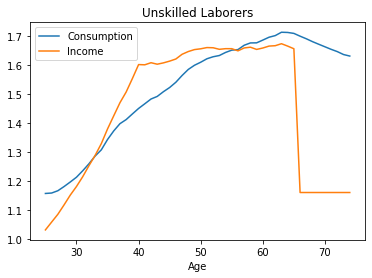

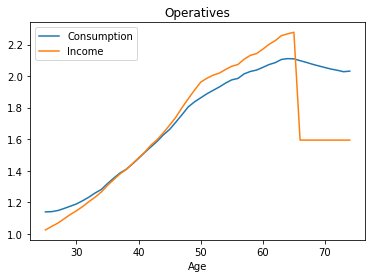

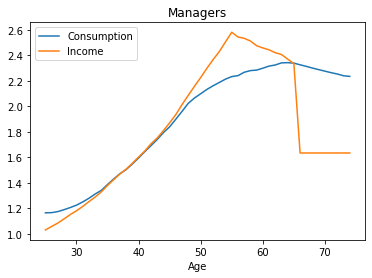

In [33]:
plt.figure()

plt.plot(AgeMeans.T_age, AgeMeans.Cons_Unskilled,label='Consumption')
plt.plot(AgeMeans.T_age, AgeMeans.Inc_Unskilled,label='Income')

plt.legend()
plt.xlabel('Age')
plt.title('Unskilled Laborers')

plt.figure()

plt.plot(AgeMeans.T_age, AgeMeans.Cons_Operatives,label='Consumption')
plt.plot(AgeMeans.T_age, AgeMeans.Inc_Operatives, label='Income')

plt.legend()
plt.xlabel('Age')
plt.title('Operatives')

plt.figure()

plt.plot(AgeMeans.T_age, AgeMeans.Cons_Managers,label='Consumption')
plt.plot(AgeMeans.T_age, AgeMeans.Inc_Managers, label='Income')

plt.legend()
plt.xlabel('Age')
plt.title('Managers')